# Tutorial 11: Joint analysis of mouse brain anterior-posterior sections

In this tutorial, we demonstrate how to integrate multiple samples of mouse brain data horizontally using STGMVA.

You can download the two sections of mouse brain data at https://zenodo.org/record/8141084.

This data is stored in "11. Mouse Brain Anterior Posterior Section 2_multi-sample integation" folder.

STGMVA could dsicern the same spatial domains in two different anterior-posterior sections of mouse brain.



## Loading package

In [10]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [2]:
from STGMVA.STGMVA import STGMMVE
from STGMVA import mk_dir

2023-07-15 17:33:09.719922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Reading ST data

In [3]:
adata = sc.read_h5ad("/home/tengliu/Paper6-NC/STGMVA_Tutorials/ST data/filtered_feature_bc_matrix.h5ad")
adata.var_names_make_unique()

In [4]:
adata

AnnData object with n_obs × n_vars = 6114 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data'
    obsm: 'spatial'

<Axes: xlabel='spatial1', ylabel='spatial2'>

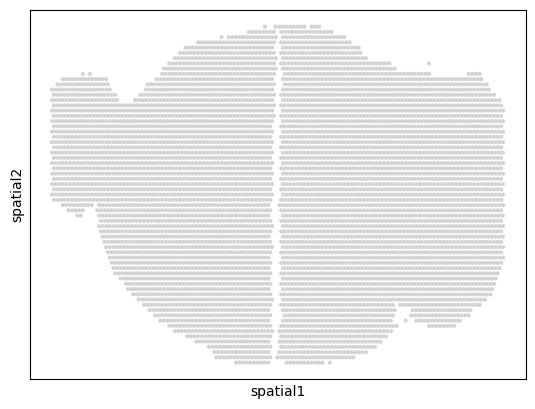

In [5]:
sc.pl.embedding(adata, basis='spatial',size=35, 
                show=False)

## Create directory for pretrained model

In [6]:
save_path='./Samp_results/'
section_id = "mouse_brain_section2_integration"
mk_dir(save_path,section_id)

## Training the model

STGMVA aims to learn the representations by two-step process. First, pretrained the GMM clustering model. Second, discerned the spatial domains for spatial transcriptomics data. 

After model training, the learned representations will be saved in adata.obsm['embedding'], and can be used for spatial clustering. 

In [8]:
model = STGMMVE(adata, datatype="mouse_brain", nCluster=26,save_path=save_path, section_id=section_id)

# model.pretrain() # Train your own pretranined model or use the pretrained model we provided.

adata_res = model.train_cluster()


Graph constructed!


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


  0%|          | 0/50 [00:15<?, ?it/s]

Epoch: 0
NMI=0.798208, ARI=0.693354
Loss=26.6892,  ELBO Loss=89.8866


 10%|█         | 5/50 [02:11<19:26, 25.92s/it]

Epoch: 5
NMI=0.755517, ARI=0.574254
Loss=27.8406,  ELBO Loss=62.3367


 20%|██        | 10/50 [03:59<15:45, 23.64s/it]

Epoch: 10
NMI=0.760985, ARI=0.576200
Loss=27.8027,  ELBO Loss=51.1024


 30%|███       | 15/50 [05:46<12:57, 22.20s/it]

Epoch: 15
NMI=0.768384, ARI=0.607746
Loss=27.7586,  ELBO Loss=46.5559


 40%|████      | 20/50 [07:26<09:43, 19.45s/it]

Epoch: 20
NMI=0.763626, ARI=0.589126
Loss=27.4439,  ELBO Loss=44.2383


 50%|█████     | 25/50 [08:43<06:59, 16.79s/it]

Epoch: 25
NMI=0.778288, ARI=0.611737
Loss=27.3582,  ELBO Loss=43.2493


 60%|██████    | 30/50 [10:15<05:31, 16.59s/it]

Epoch: 30
NMI=0.767700, ARI=0.588367
Loss=27.2577,  ELBO Loss=42.6749


 70%|███████   | 35/50 [11:47<04:41, 18.77s/it]

Epoch: 35
NMI=0.768342, ARI=0.602319
Loss=27.2522,  ELBO Loss=42.2562


 80%|████████  | 40/50 [13:22<03:01, 18.14s/it]

Epoch: 40
NMI=0.751411, ARI=0.563726
Loss=27.1699,  ELBO Loss=41.8975


 90%|█████████ | 45/50 [14:48<01:33, 18.79s/it]

Epoch: 45
NMI=0.792349, ARI=0.657427
Loss=27.1688,  ELBO Loss=41.7008


100%|██████████| 50/50 [15:57<00:00, 19.15s/it]


In [9]:
adata_res

AnnData object with n_obs × n_vars = 6114 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data', 'pre_label'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'mclust_labels', 'ari_list', 'loss'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'feat_mat', 'embedding'

### Here, we discuss the PCA reduction and refinement of the learned representations.

### For the downstream clustering method, we use the mclust clustering method.

### No PCA reduction and refinement of the learned representations

In [11]:
nClusters = 26
def mclust_R(embedding, num_cluster, modelNames='EEE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']
    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(
        embedding), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    mclust_res = mclust_res.astype('int')
    # mclust_res = mclust_res.astype('category')
    return mclust_res

def prediction(z):
    pred_mclust = mclust_R(embedding=z,num_cluster=nClusters)
    return pred_mclust

label1 = prediction(adata_res.obsm["embedding"])
adata_res.obs['pca_refine_no'] = label1
adata_res.obs['pca_refine_no'] = adata_res.obs['pca_refine_no'].astype("category")

### Only no refinement of the learned representations

In [12]:
nClusters = 26
def mclust_R(embedding, num_cluster, modelNames='EEE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']
    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(
        embedding), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    mclust_res = mclust_res.astype('int')
    # mclust_res = mclust_res.astype('category')
    return mclust_res

def prediction(z):
    pca20 = PCA(n_components=30)
    pca_z = pca20.fit_transform(z)
    pred_mclust = mclust_R(embedding=pca_z,num_cluster=nClusters)
    return pred_mclust

label2 = prediction(adata_res.obsm["embedding"])
adata_res.obs['refine_no'] = label2
adata_res.obs['refine_no'] = adata_res.obs['refine_no'].astype("category")

## Visualization

### figure1

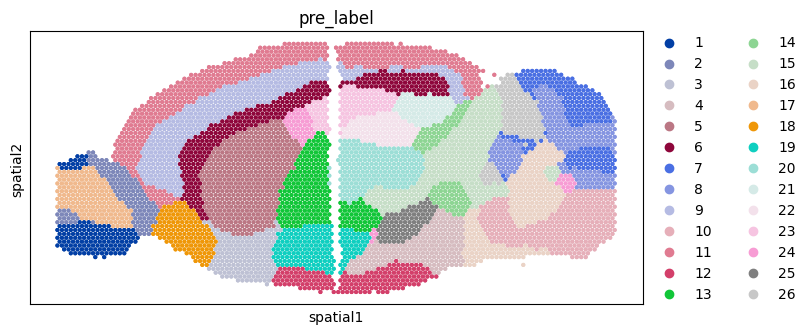

In [13]:
sq.pl.spatial_scatter(adata_res, color="pre_label", size=15, figsize=(8,6),shape=None)

### figure2

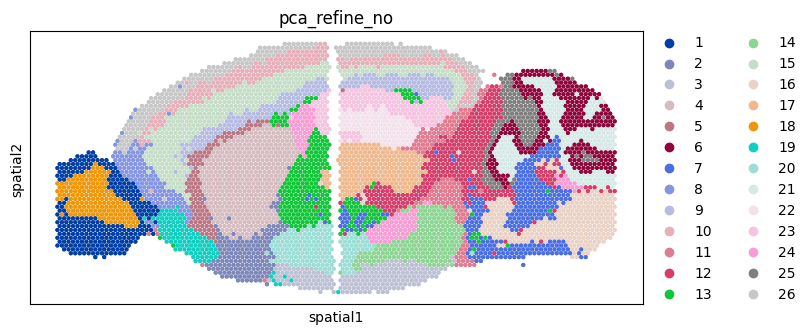

In [14]:
sq.pl.spatial_scatter(adata_res, color="pca_refine_no", size=15, figsize=(8,6),shape=None)

### figure3

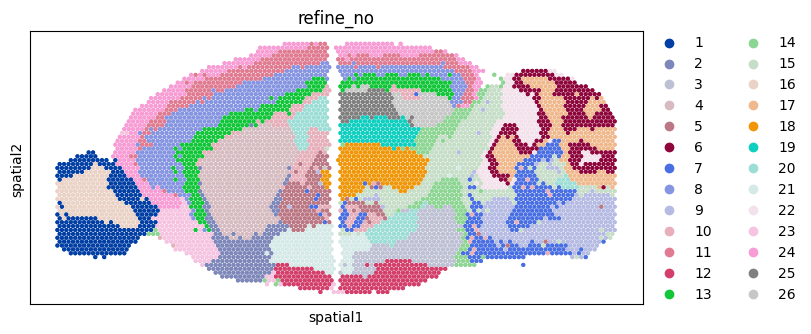

In [15]:
sq.pl.spatial_scatter(adata_res, color="refine_no", size=15, figsize=(8,6),shape=None)

## Save the results for more figures

In [16]:
adata_res.filename = './'+"mouse_brain2_integration.h5ad"